persons: 14221 | clothes: 14221


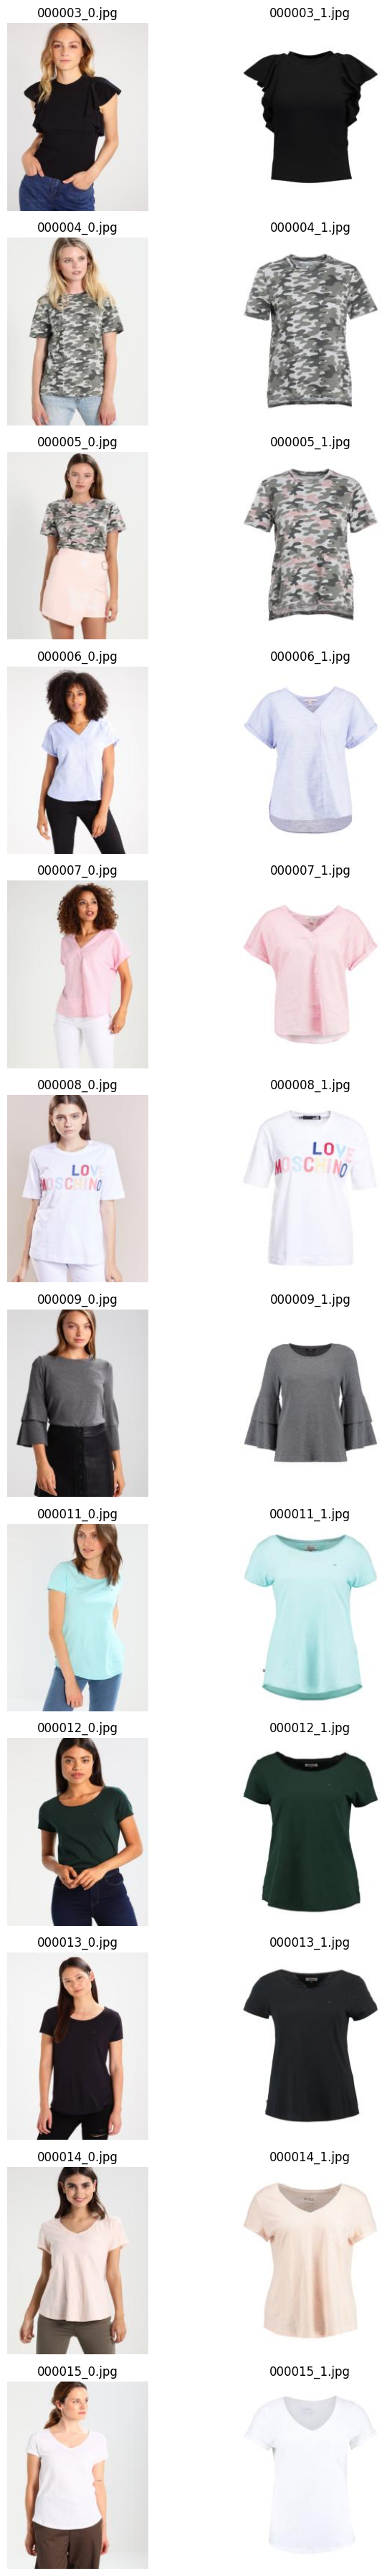

In [33]:
import os
from PIL import Image
import matplotlib.pyplot as plt

IMG_DIR = "/Users/chaitanyakakade/Desktop/VITON/ACGPN_TrainData/train_img"     # people (JPGs)
CLO_DIR = "/Users/chaitanyakakade/Desktop/VITON/ACGPN_TrainData/train_color"   # clothes (JPGs)

# get .jpg files only (case-insensitive), sorted for reproducibility
persons = sorted([f for f in os.listdir(IMG_DIR) if f.lower().endswith(".jpg")])
clothes = sorted([f for f in os.listdir(CLO_DIR) if f.lower().endswith(".jpg")])

print(f"persons: {len(persons)} | clothes: {len(clothes)}")

k = min(len(persons), len(clothes), 12)  # show up to 12 rows
if k == 0:
    raise SystemExit("No JPGs found in one or both folders. Check paths and file names.")

fig, axes = plt.subplots(k, 2, figsize=(8, 3*k))
if k == 1:
    axes = [axes]  # make iterable if only one row

for i in range(k):
    p_path = os.path.join(IMG_DIR, persons[i])
    c_path = os.path.join(CLO_DIR, clothes[i])

    p_img = Image.open(p_path).convert("RGB")
    c_img = Image.open(c_path).convert("RGB")

    axes[i][0].imshow(p_img); axes[i][0].set_title(persons[i]); axes[i][0].axis("off")
    axes[i][1].imshow(c_img); axes[i][1].set_title(clothes[i]); axes[i][1].axis("off")

plt.tight_layout()
plt.show()


Person: 000003_0.jpg | Cloth: 016955_1.jpg


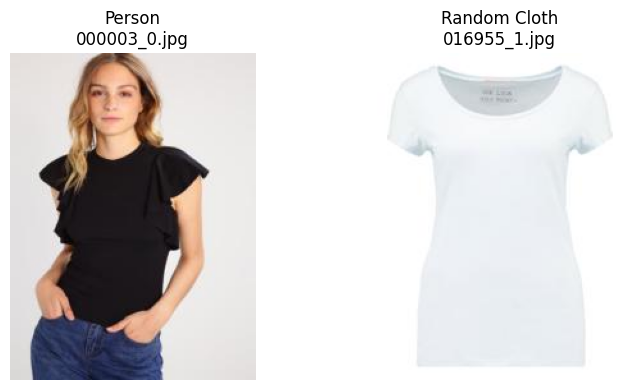

In [34]:
import os, random, re
from PIL import Image
import matplotlib.pyplot as plt



def base_id(fname):
    # "000123_0.jpg" -> "000123"
    m = re.match(r"(\d+)_\d+\.jpg$", fname)
    return m.group(1) if m else None

persons = sorted([f for f in os.listdir(IMG_DIR) if f.lower().endswith(".jpg")])
clothes = sorted([f for f in os.listdir(CLO_DIR) if f.lower().endswith(".jpg")])

if not persons or not clothes:
    raise SystemExit("No JPGs found. Check IMG_DIR and CLO_DIR.")


p_fn = persons[0] 
p_id = base_id(p_fn)


different_clothes = [c for c in clothes if base_id(c) != p_id]
if not different_clothes:
    raise SystemExit("Could not find a clothing item with a different base id.")
c_fn = random.choice(different_clothes)

p_img = Image.open(os.path.join(IMG_DIR, p_fn)).convert("RGB")
c_img = Image.open(os.path.join(CLO_DIR, c_fn)).convert("RGB")

print("Person:", p_fn, "| Cloth:", c_fn)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(p_img); ax[0].set_title(f"Person\n{p_fn}"); ax[0].axis("off")
ax[1].imshow(c_img); ax[1].set_title(f"Random Cloth\n{c_fn}"); ax[1].axis("off")
plt.tight_layout(); plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mediapipe as mp

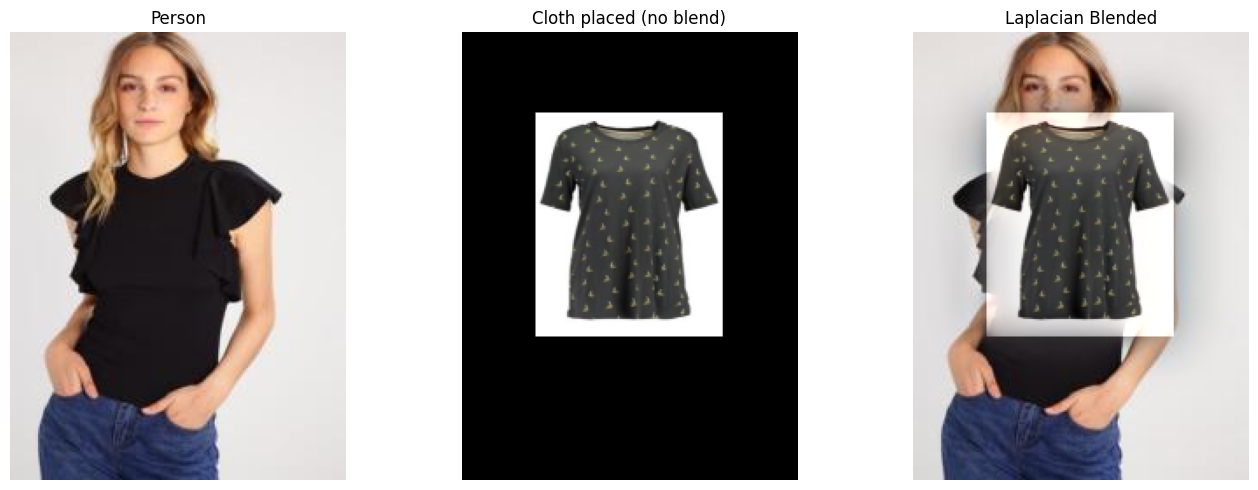

In [36]:


import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image


p_img = Image.open("/Users/chaitanyakakade/Desktop/VITON/ACGPN_TrainData/train_img/000003_0.jpg").convert("RGB")
c_img = Image.open("/Users/chaitanyakakade/Desktop/VITON/ACGPN_TrainData/train_color/000999_1.jpg").convert("RGB")

person = np.array(p_img)  # HxWx3 RGB
cloth  = np.array(c_img)

H, W = person.shape[:2]


x_ratio = 0.22   # how much of width to trim from left/right
y_top   = 0.18   # top of torso as fraction of height
y_bot   = 0.68   # bottom of torso as fraction of height

x1 = int(W * x_ratio)
x2 = int(W * (1 - x_ratio))
y1 = int(H * y_top)
y2 = int(H * y_bot)

# --- 2) Resize cloth to the torso box size ---
box_w, box_h = x2 - x1, y2 - y1
cloth_resized = cv2.resize(cloth, (box_w, box_h), interpolation=cv2.INTER_AREA)


cloth_canvas = np.zeros_like(person)
cloth_canvas[y1:y2, x1:x2] = cloth_resized

mask_bin = np.zeros((H, W), dtype=np.uint8)
mask_bin[y1:y2, x1:x2] = 255


mask_soft = cv2.GaussianBlur(mask_bin, (0, 0), sigmaX=5, sigmaY=5).astype(np.float32) / 255.0
mask_soft = np.dstack([mask_soft]*3)  # HxWx3

# --- 4) Laplacian pyramid blending ---
def build_gaussian_pyramid(img, levels=5):
    gp = [img.astype(np.float32)]
    for _ in range(1, levels):
        img = cv2.pyrDown(img)
        gp.append(img.astype(np.float32))
    return gp

def build_laplacian_pyramid(img, levels=5):
    gp = build_gaussian_pyramid(img, levels)
    lp = []
    for i in range(levels-1):
        up = cv2.pyrUp(gp[i+1], dstsize=(gp[i].shape[1], gp[i].shape[0]))
        lp.append(gp[i] - up)
    lp.append(gp[-1])
    return lp

def reconstruct_from_laplacian(lp):
    img = lp[-1]
    for i in range(len(lp)-2, -1, -1):
        up = cv2.pyrUp(img, dstsize=(lp[i].shape[1], lp[i].shape[0]))
        img = up + lp[i]
    return np.clip(img, 0, 255).astype(np.uint8)

def laplacian_blend(img_a, img_b, mask, levels=5):
    # img_a: person, img_b: cloth_canvas, mask: soft mask in [0,1]
    lp_a = build_laplacian_pyramid(img_a, levels)
    lp_b = build_laplacian_pyramid(img_b, levels)
    gp_m = build_gaussian_pyramid(mask, levels)

    blended = []
    for la, lb, gm in zip(lp_a, lp_b, gp_m):
        if gm.ndim == 2:
            gm = gm[..., None]
        blended.append(gm * lb + (1.0 - gm) * la)
    return reconstruct_from_laplacian(blended)

blended = laplacian_blend(person, cloth_canvas, mask_soft, levels=5)

fig, ax = plt.subplots(1, 3, figsize=(14,5))
ax[0].imshow(person);      ax[0].set_title("Person"); ax[0].axis("off")
ax[1].imshow(cloth_canvas);ax[1].set_title("Cloth placed (no blend)"); ax[1].axis("off")
ax[2].imshow(blended);     ax[2].set_title("Laplacian Blended"); ax[2].axis("off")
plt.tight_layout(); plt.show()
